In [68]:
%matplotlib inline
import torch
import torchvision
import math
import seaborn as sns
import pandas as pd

In [2]:
import sys
sys.path.append('..')

In [70]:
from train import cifar_stats

In [3]:
path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit.pkl'

In [4]:
model = torch.load(path, map_location=torch.device('cpu'))

In [15]:
params = [(layer._quadratic.weight, layer.weight, layer.bias) 
           for layer in model.features if hasattr(layer, '_quadratic')]

In [16]:
(qw, w, b), = params
fan_in = w.shape[1] # this is to accommodate my initial incorrect implementation

# Examining weight and bias magnitudes

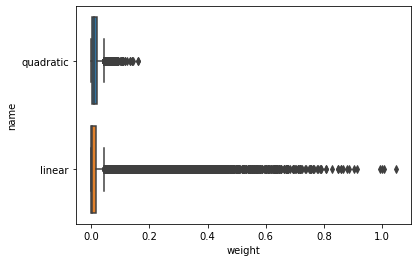

In [94]:
qw_magnitude = qw.abs().flatten().detach()
w_magnitude = w.abs().flatten().detach()
weights = pd.concat([
    pd.DataFrame({'weight': qw_magnitude}).assign(name='quadratic'),
    pd.DataFrame({'weight': w_magnitude}).assign(name='linear')
])    
_ = sns.boxplot(x='weight', y='name', data=weights)

In [95]:
pd.Series(qw_magnitude).describe()

count    1.382400e+04
mean     1.443472e-02
std      1.402033e-02
min      2.069360e-09
25%      4.362878e-03
50%      1.027833e-02
75%      2.053841e-02
max      1.620958e-01
dtype: float64

In [96]:
pd.Series(w_magnitude).describe()

count    1.382400e+04
mean     4.434614e-02
std      1.094410e-01
min      2.576421e-09
25%      2.517860e-04
50%      1.947631e-03
75%      1.812685e-02
max      1.046408e+00
dtype: float64

In [99]:
pd.Series(b.detach()).describe()

count    512.000000
mean      -0.599834
std        0.168443
min       -1.326158
25%       -0.708422
50%       -0.598861
75%       -0.507021
max        0.029849
dtype: float64

# Calculating radii

Recall that the net input is calculated as:

$z = \alpha_t \sum_{i=1}^m w^\prime_i x_i^2 + \alpha_t \gamma + \sum_{i=1}^m w_i x_i + b,$

where $\{w^\prime_i\}$ (called quadratic weights here) are constrained to be negative, $\alpha_t=1$ when training is finished, and $\gamma = \sqrt{\text{fan-in}}$.

We rewrite the formula into:

$z = \sum_{i=1}^m w^\prime_i \left(x_i + \frac{w_i}{2w^\prime_i} \right)^2 \underbrace{- \frac{1}{4} \left( \frac{w_i}{w^\prime_i} \right)^2 + \sqrt{\text{fan-in}} + b}_{b_0},$

and therefore, the boundary is defined as:

$\sum_{i=1}^m w^\prime_i \left(x_i - x^*_i\right)^2 + b_0 = 0$

$\sum_{i=1}^m \frac{\left(x_i - x^*_i\right)^2}{\left(\frac{b_0}{-w^\prime_i}\right)} - 1 = 0$ (notice that $w^\prime_i$ is required to be negative)

So, the radii are $\sqrt{\left| \frac{b_0}{-w^\prime_i} \right|}$

In [52]:
w = w.reshape(w.shape[0],-1)
qw = qw.reshape(w.shape[0],-1)
b0 = -0.25*torch.sum((w/qw)**2, axis=1) + math.sqrt(fan_in) + b

In [77]:
radii = torch.sqrt((b0.reshape(b0.shape[0],1)/qw).abs()).flatten().detach()

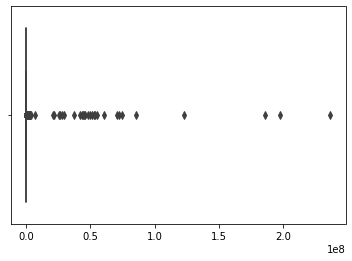

In [79]:
_ = sns.boxplot(radii)

In [80]:
radii_series = pd.Series(radii)
radii_series.describe()

count    1.382400e+04
mean     1.400700e+05
std      3.828484e+06
min      1.898688e-01
25%      1.288414e+01
50%      5.751820e+01
75%      4.539029e+02
max      2.363871e+08
dtype: float64

In [83]:
(radii_series < 1).mean()

0.004195601851851852

In [84]:
(radii_series < 2).mean()

0.012369791666666666

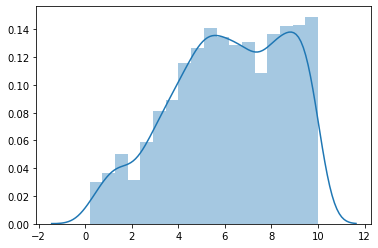

In [106]:
_ = sns.distplot(radii_series[radii_series < 10])

# Compare to input distribution

In [71]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [72]:
x, y = next(iter(cifar10_testloader))

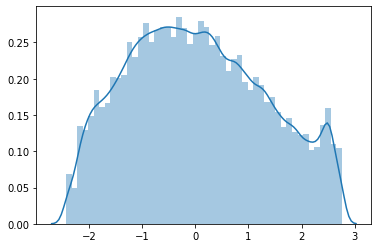

In [73]:
sns.distplot(x.flatten())

In [75]:
x.std().item()

1.2921929359436035

In [76]:
pd.Series(x.flatten()).describe()

count    786432.000000
mean          0.048784
std           1.292193
min          -2.429066
25%          -0.972734
50%          -0.036240
75%           1.003776
max           2.753731
dtype: float64

# Apply elliptical filters on actual data

In [101]:
elliptical_layer, = [layer for layer in model.features if hasattr(layer, '_quadratic')]

In [102]:
z = elliptical_layer(x)

In [103]:
z.shape

torch.Size([256, 512, 32, 32])

In [105]:
(z > 0).float().mean() # density

tensor(0.7887)